In [94]:
# ! -*- coding: utf-8 -*-
import os.path
import torch
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModel,GPT2Tokenizer
import numpy as np
from utls import GPT2LinearOutput,caculate,caculater2
import pandas as pd

# pip install seaborn -i https://pypi.tuna.tsinghua.edu.cn/simple
import seaborn as sns

tokenizer = GPT2Tokenizer.from_pretrained(r"D:\system\桌面\lcm-code\tokenizers_lcm\tokenizer_gpt100.json")
tokenizer.pad_token = tokenizer.eos_token

model =GPT2LinearOutput(8,0.2,0.13)
model.load_state_dict(torch.load('best_val.model'))

<All keys matched successfully>

In [95]:
# 打印
import torch
def attention_plot(names,smi,attention, x_texts, y_texts=None, figsize=(25, 20), annot=False, figure_path='./figures',
                   figure_name='attention_weight.png'):
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.clf()
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width*20, bbox.height*20

    rows, cols = attention.shape

    # 计算自适应字体大小
    fontsize = int(0.9 * min(width / cols, height / rows))

    sns.set(font_scale=2.5)
    hm = sns.heatmap(attention,
                     cbar=True,
                     cmap="RdBu_r",
                     annot=annot,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': fontsize},
                     yticklabels=y_texts,
                     xticklabels=x_texts,
                     )
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold',fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold',fontsize=fontsize)

    ax.text(0.5, 1.05, names, ha='center', va='bottom', fontsize=50, transform=ax.transAxes)


    ax.text(0.5, -0.1, smi, ha='center', va='bottom', fontsize=50, transform=ax.transAxes)
    rect = plt.Rectangle((0, len(y_texts)-1), len(x_texts), 1, fill=False, edgecolor='red', lw=3)
    ax.add_patch(rect)


    if os.path.exists(figure_path) is False:
        os.makedirs(figure_path)
    plt.savefig(os.path.join(figure_path, figure_name))
    plt.close()

In [96]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset,load_from_disk
from  utls import caculate
# \t is the tab character in Python
dataset_dict = load_from_disk('dataset_aug')


In [119]:
tokenized_dataset = dataset_dict.map(
    lambda element: tokenizer(element['smi']),batched=True
)
def returnlength(example):
    return  {'length':len(example['input_ids'])-1}

tokenized_dataset.set_format("torch")

tokenized_dataset=tokenized_dataset.map(returnlength)['test']
tokenized_dataset

Dataset({
    features: ['num', 'Names', 'smi', 'Ref', 'logkOH•', 'outliers', 'train_set', 'valid_set', 'test_set', 'AD_screening', 'input_ids', 'attention_mask', 'length'],
    num_rows: 138
})

In [125]:
import re
tokenized_dataset=tokenized_dataset.select_columns(['Names','smi','input_ids','attention_mask','logkOH•','length'])

test_dataloader=DataLoader(tokenized_dataset, batch_size=1)


tokenized_dataset = tokenized_dataset.map(lambda x: {'Names': re.sub(r'[^\x00-\x7F]+', '', x['Names']).replace(' ', '_').replace('/', '_')})

tokenized_dataset['Names']

Map:   0%|          | 0/138 [00:00<?, ? examples/s]

['2-propanol',
 '1-butanol',
 'sulfadiazine',
 'glyoxylic_acid',
 '2-chloropyridine',
 'benzamide',
 'Uridine',
 'glucose-1-phosphate',
 '1-Pentanol',
 'ethane',
 'Riboflavin',
 '2-Deoxy-D-galactosamine',
 '1-phenyl-1-propanol',
 'o-cresol',
 '1,3-dimethylurea',
 'a-methylstyrene',
 'Adrenalone',
 'ethyl_propionate',
 '1-Butene',
 'toluene',
 'Furan',
 'hexane',
 '1-Octanol',
 'dimethylether',
 'N-Methylformamide',
 '2-hydroxyethylethylenediaminetriaceticacid',
 '1,4-dimethoxybenzene',
 '6-Azauracil',
 '1,2,3,4-tetramethyl_benzene',
 '2-aminoacetamid',
 '1-methylindole',
 '1,3-dimethylindole',
 '1,2-dimethylindole',
 '6-Dimethylaminopurine',
 '6-Methoxypurine',
 'Methylgalactoside',
 'N6-methyladenosine_6-methylaminopurine_9-ribofuranoside',
 'Isopropyl_phenyl_sulfoxide',
 '3,5-Dinitroanisole',
 'Melibiose',
 '_1-(p-Bromophenyl)ethanol',
 'Glycyltyrosylglycine',
 'benzoflavine',
 '2,3-dihydro-5-hydroxy-1,4-phthalazinedione',
 '2-mercaptopurine',
 '2,2,2-trichloro_ethanol',
 'Carbon_dis

In [126]:
for idx,batch in enumerate(test_dataloader):
    model.eval()
    ids = np.array(batch['input_ids'][0], dtype=np.int64)
    texts=tokenizer.convert_ids_to_tokens(ids)
    outputs=model(batch['input_ids'],attention_mask=batch['attention_mask'])[1]
    attentions=outputs[0]

    attention_mean = torch.mean(attentions, axis=1)

    name=batch['Names']
    # Attention 归一化
    attentions_norm = torch.nn.functional.normalize(attention_mean, dim=-1,p=1)
    attention_plot(name[0],batch['smi'][0],attentions_norm[0, :, :].detach().numpy(), x_texts=texts, y_texts=texts, annot=True, figsize=(24, 20),
                   figure_path='.\explain',
                   figure_name=rf'{name[0]}.png')


<Figure size 640x480 with 0 Axes>

In [0]:

model.eval()
example='Cc1cc(C)nc(NS(=O)(=O)c2ccc(N)cc2)n1'
name='Sulfamethazine'
batch=tokenizer(example,return_tensors='pt')
ids = np.array(batch['input_ids'][0], dtype=np.int64)

texts=tokenizer.convert_ids_to_tokens(ids)
outputs=model(batch['input_ids'],attention_mask=batch['attention_mask'])[1]

attentions=outputs[0]

attention_mean = torch.mean(attentions, axis=1)
attentions_norm = torch.nn.functional.normalize(attention_mean, dim=-1,p=1)

df=np.array([attentions_norm[0, -1,:].detach().numpy()])

attention_plot('','',df, x_texts=texts, y_texts=[''],annot=True, figsize=(24, 20),
               figure_path='.\hydroxyl_radical',
               figure_name=rf'{name}.png')
df.shape

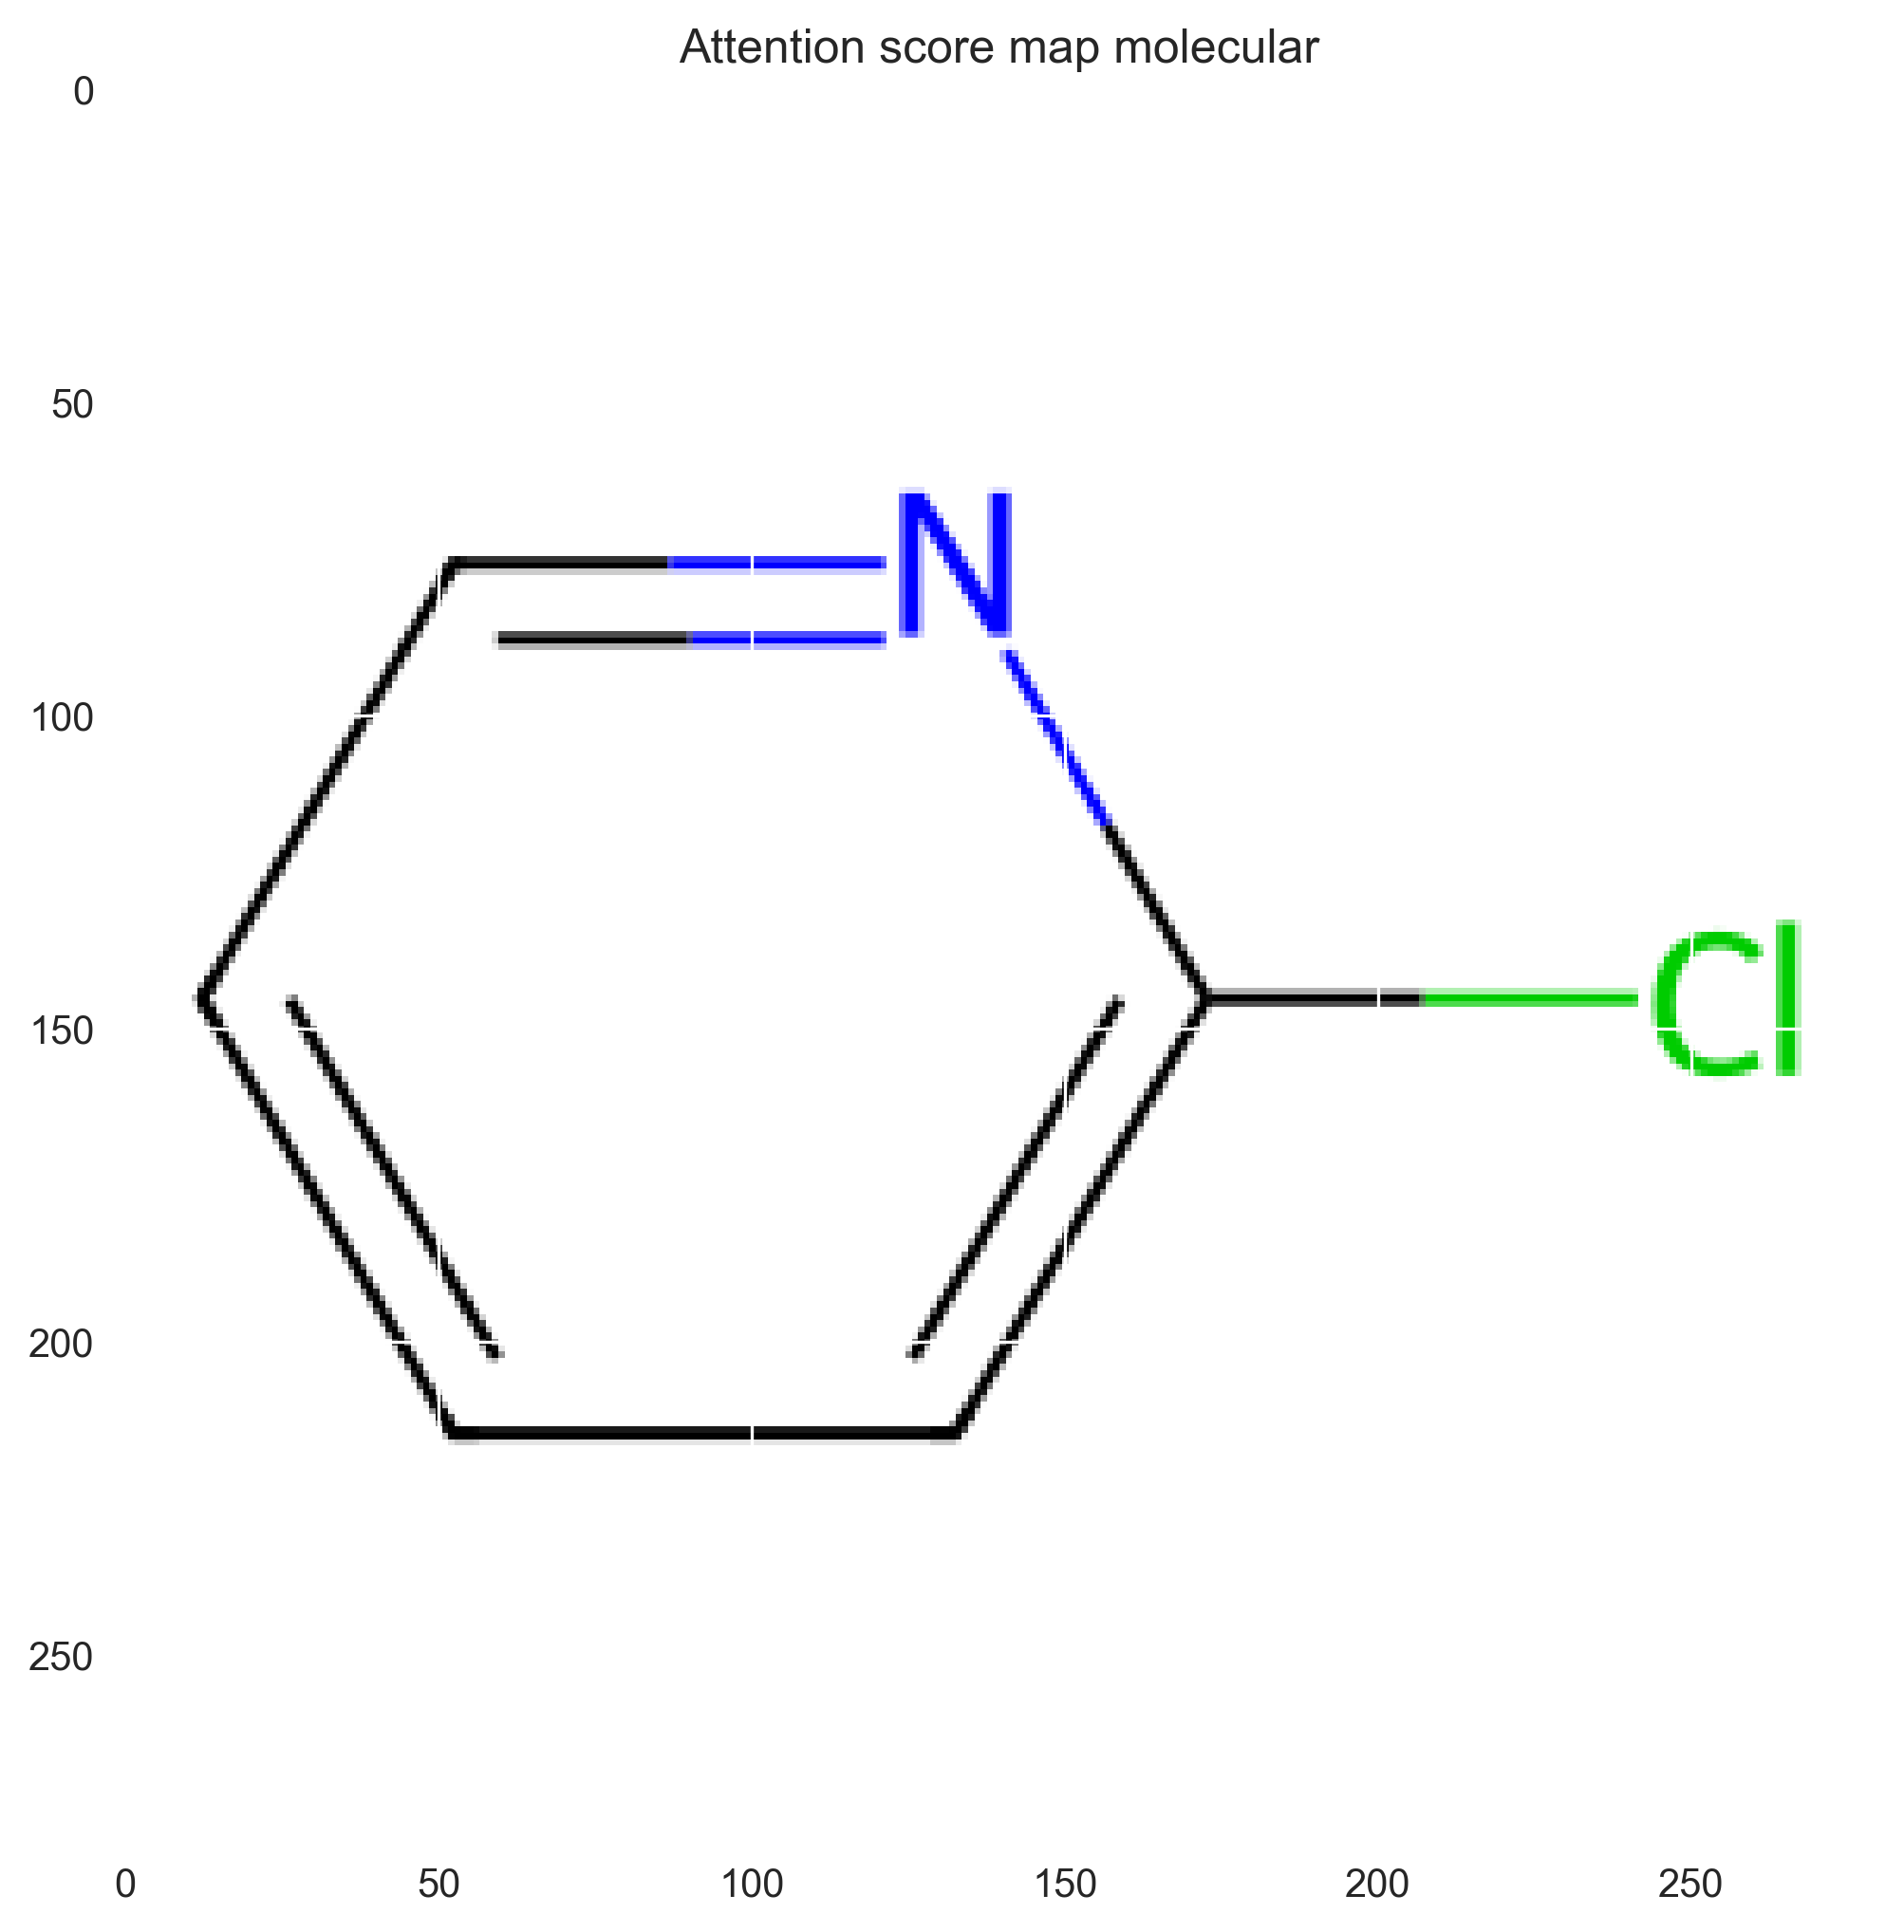

In [2]:
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import rdDepictor, rdmolops
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib
import matplotlib.cm as cm
from skimage.io import imread
from cairosvg import svg2png
import os



def img_for_mol(mol, atom_weights=[]):
    # print(atom_weights)
    highlight_kwargs = {}
    if len(atom_weights) > 0:
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
        cmap = matplotlib.colormaps['bwr']
        plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
        atom_colors = {
            i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))
        }
        highlight_kwargs = {
            'highlightAtoms': list(range(len(atom_weights))),
            'highlightBonds': [],
            'highlightAtomColors': atom_colors,
            'highlightBondColors':[]
        }
        # print(highlight_kwargs)

    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(6)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, **highlight_kwargs)
                        # highlightAtoms=list(range(len(atom_weights))),
                        # highlightBonds=[],
                        # highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    svg2png(bytestring=svg, write_to='tmp.png', dpi=600)
    img = imread('tmp.png')


    os.remove('tmp.png')

    return img

mol = Chem.MolFromSmiles('Clc1ccccn1')
# img = img_for_mol(mol, atom_weights=[0.48,
# 0.02,
#
# 0.25,
# 0.01,
# 0.02,
# 0.03,
#
# 0.13
# ])
img = img_for_mol(mol)
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8),dpi=300)

# Display the image
ax.imshow(img)

# Set title and axis labels
ax.set_title('Attention score map molecular')


plt.show()